In [260]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd

# Load in the data and get only the section from when after the thermocouple
# was inserted into the cylinder, and define some useful constants.
forced_high_data = np.loadtxt(
    "./Data/Lab2/forced_high.csv", delimiter=",", skiprows=7, usecols=[1, 2, 3]
)
max_idx = forced_high_data[:, 1].argmax()
forced_high_data[:, 0] -= forced_high_data[max_idx, 0]
forced_high_data = forced_high_data[max_idx:, :]
Ti_high = forced_high_data[0, 1]
Tinf_high = forced_high_data[:, 2].mean()
time_high = forced_high_data[:, 0].max()

forced_low_data = np.loadtxt(
    "./Data/Lab2/forced_low.csv", delimiter=",", skiprows=7, usecols=[1, 2, 3]
)
max_idx = forced_low_data[:, 1].argmax()
forced_low_data[:, 0] -= forced_low_data[max_idx, 0]
forced_low_data = forced_low_data[max_idx:, :]
Ti_low = forced_low_data[0, 1]
Tinf_low = forced_low_data[:, 2].mean()
time_low = forced_low_data[:, 0].max()

natural_data = np.loadtxt(
    "./Data/Lab2/natural.csv", delimiter=",", skiprows=7, usecols=[1, 2, 3]
)
max_idx = natural_data[:, 1].argmax()
natural_data[:, 0] -= natural_data[max_idx, 0]
natural_data = natural_data[max_idx:, :]
Ti_natural = natural_data[0, 1]
Tinf_natural = natural_data[:, 2].mean()
time_natural = natural_data[:, 0].max()


In [274]:
# Analytical Solution


def analyticalT_dless(t, tau):
    return np.exp(-t / tau)


def h_analytical(tau, m, cp, surfA):
    return (m * cp) / (tau * surfA)


# Aluminum 6061-T6 material properties from https://asm.matweb.com/search/SpecificMaterial.asp?bassnum=ma6061t6
density = 2700  # kg m^-3
cp = 896  # J kg^-1 K^-1
k = 167  # W m^-1 K^-2
alpha = k / (density * cp)
# Cylinder properties from Lab 2 Handout
cylinder_height = 0.075  # m
cylinder_diameter = 0.025  # m
cylinder_radius = cylinder_diameter / 2
surface_area = np.pi * cylinder_diameter * cylinder_height  # m^2
cylinder_volume = np.pi / 4 * cylinder_diameter**2 * cylinder_height
cylinder_mass = cylinder_volume * density  # kg

# Get the dimensionless temperatures for each type of flow
dlessT_high = (forced_high_data[:, 1] - forced_high_data[:, 2].mean()) / (
    forced_high_data[0, 1] - forced_high_data[:, 2].mean()
)
dlessT_low = (forced_low_data[:, 1] - forced_low_data[:, 2].mean()) / (
    forced_low_data[0, 1] - forced_low_data[:, 2].mean()
)
dlessT_natural = (natural_data[:, 1] - natural_data[:, 2].mean()) / (
    natural_data[0, 1] - natural_data[:, 2].mean()
)

# Optimize to find the tau value, then compute the h value
tau_high, pcov = opt.curve_fit(
    analyticalT_dless, forced_high_data[:, 0], dlessT_high, p0=100
)
tau_high = tau_high[0]
perr = np.sqrt(np.diag(pcov))
print(perr)
h_high = h_analytical(tau_high, cylinder_mass, cp, surface_area)
print(h_high)
tau_low, pcov = opt.curve_fit(analyticalT_dless, forced_low_data[:, 0], dlessT_low, p0=100)
tau_low = tau_low[0]
perr = np.sqrt(np.diag(pcov))
print(perr)
h_low = h_analytical(tau_low, cylinder_mass, cp, surface_area)
print(h_low)
tau_natural, pcov = opt.curve_fit(
    analyticalT_dless, natural_data[:, 0], dlessT_natural, p0=100
)
tau_natural = tau_natural[0]
perr = np.sqrt(np.diag(pcov))
print(perr)
h_natural = h_analytical(tau_natural, cylinder_mass, cp, surface_area)
print(h_natural)

print()

biot_high = h_high * cylinder_diameter / k 
biot_low = h_low * cylinder_diameter / k 
biot_natural = h_natural * cylinder_diameter / k 

print("Biot Numbers:")
print(biot_high)
print(biot_low)
print(biot_natural)


[0.61304113]
29.711029137661274
[0.73234186]
23.601393292741434
[0.81999177]
10.96909190524705

Biot Numbers:
0.004447758852943305
0.0035331427084942272
0.0016420796265339895


In [262]:
# Emperical Solution

k_air = 2.623e-2 # W m^-1 K^-1
density_air = 1.225  # kg m^-3
visc_air = 1.789e-5  # Pa s


def h_emperical(vel):
    reynolds = vel * density_air * cylinder_diameter / visc_air
    nusselt = 0.683 * (reynolds**0.466) * (0.71 ** (1 / 3))
    return nusselt * k_air / cylinder_diameter


vel_high = 1.1  # m s^-1
print(h_emperical(vel_high))

vel_low = 0.6  # m s^-1
print(h_emperical(vel_low))


21.467549310046675
16.184972302351355


In [263]:
# Numerical Solution
# The following are from the optimization further down
# High params:
#  (0.002, 0.008, 0.002, 0.15434053438507775)
# ---- 
# Low params:
#  (0.003, 0.014, 0.003, 0.17355170861815905)
# ----
# Natural params:
#  (0.003, 0.014, 0.003, 0.11535986458049904)
# ----

flow_condition_data = {
    "high": (Ti_high, Tinf_high, time_high, h_high, 0.002, 0.008),
    "low": (Ti_low, Tinf_low, time_low, h_low, 0.003, 0.014),
    "natural": (Ti_natural, Tinf_natural, time_natural, h_natural, 0.003, 0.014),

}

def numerical_solution(Ti, Tinf, time, h, dr, dt):

    x_steps = np.arange(0, cylinder_radius, dr)
    t_steps = np.arange(0, time, dt)

    n_x = len(x_steps)
    n_t = len(t_steps)

    s = alpha * dt / dr**2
    if s > 0.5:
        print(f"S is too large {s}")
        return 

    T = np.zeros((n_t, n_x))

    T[0] = Ti

    for m in range(1, n_t):
        for i in range(1, n_x - 1):
            a_i = s - s / (2 * i)
            b_i = 1 - 2 * s
            c_i = s + s / (2 * i)

            T[m, i] = a_i * T[m - 1, i - 1] + b_i * T[m - 1, i] + c_i * T[m - 1, i + 1]

            T[m, 0] = T[m, 1]

            H = -h * surface_area * dt / (cylinder_mass * cp)
            T[m, -1] = H * (T[m - 1, -1] - Tinf) + T[m - 1, -1]
    return x_steps, t_steps, T



x_steps_high, t_steps_high, sol_high = numerical_solution(*flow_condition_data["high"])
x_steps_low, t_steps_low, sol_low = numerical_solution(*flow_condition_data["low"])
x_steps_natural, t_steps_natural, sol_natural = numerical_solution(*flow_condition_data["natural"])





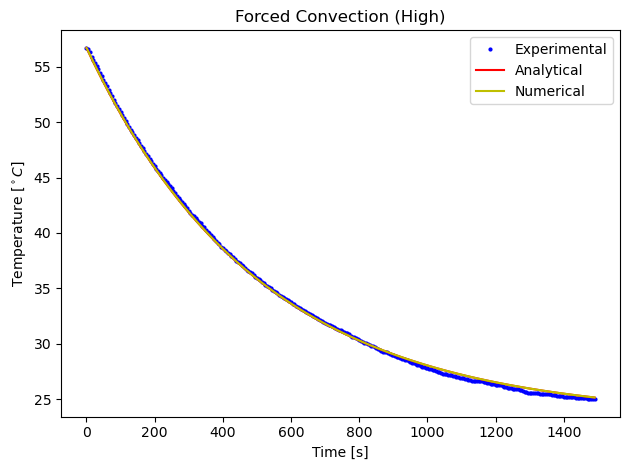

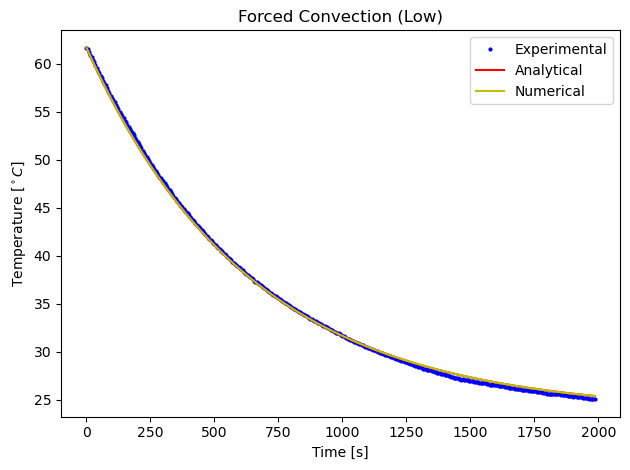

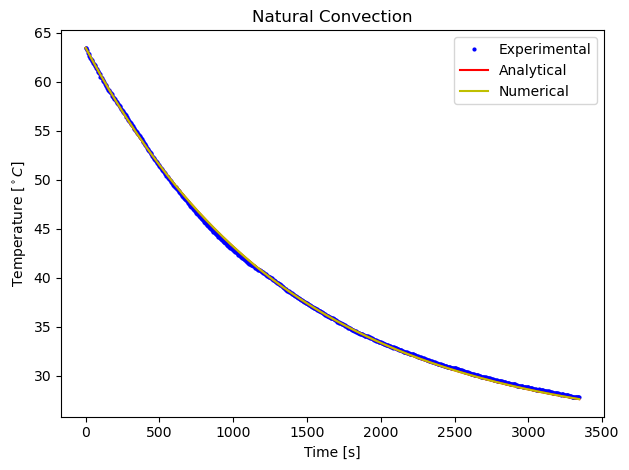

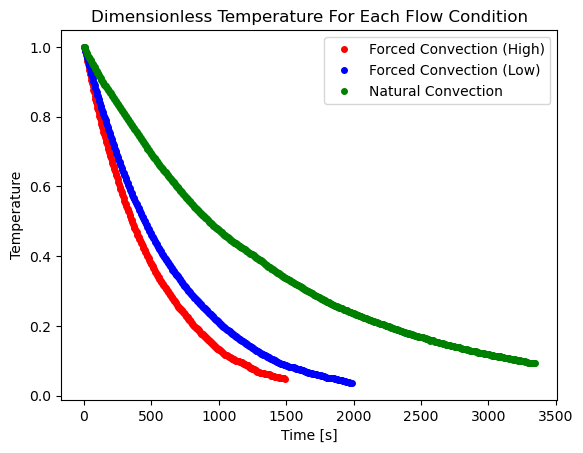

In [271]:
# Plotting
def analyticalT(t, tau, Ti, Tinf):
    return (Ti - Tinf) * np.exp(-t / tau) + Tinf


fig_dpi = 100

plt.figure(dpi=fig_dpi)
plt.plot(
    forced_high_data[:, 0],
    forced_high_data[:, 1],
    "bo",
    label="Experimental",
    markersize=2,
)
plt.plot(
    forced_high_data[:, 0],
    analyticalT(forced_high_data[:, 0], tau_high, Ti_high, Tinf_high),
    "r-",
    label="Analytical",
)
plt.plot(t_steps_high, sol_high[:, 0], "y-", label="Numerical")
plt.ylabel("Temperature [$^\circ C$]")
plt.xlabel("Time [s]")
plt.title("Forced Convection (High)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(dpi=fig_dpi)
plt.plot(
    forced_low_data[:, 0],
    forced_low_data[:, 1],
    "bo",
    label="Experimental",
    markersize=2,
)
plt.plot(
    forced_low_data[:, 0],
    analyticalT(forced_low_data[:, 0], tau_low, Ti_low, Tinf_low),
    "r-",
    label="Analytical",
)
plt.plot(t_steps_low, sol_low[:, 0], "y-", label="Numerical")
plt.ylabel("Temperature [$^\circ C$]")
plt.xlabel("Time [s]")
plt.title("Forced Convection (Low)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(dpi=fig_dpi)
plt.plot(
    natural_data[:, 0],
    natural_data[:, 1],
    "bo",
    label="Experimental",
    markersize=2,
)
plt.plot(
    natural_data[:, 0],
    analyticalT(natural_data[:, 0], tau_natural, Ti_natural, Tinf_natural),
    "r-",
    label="Analytical",
)
plt.plot(t_steps_natural, sol_natural[:, 0], "y-", label="Numerical")

plt.title("Natural Convection")
plt.ylabel("Temperature [$^\circ C$]")
plt.xlabel("Time [s]")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(dpi=fig_dpi)
plt.plot(forced_high_data[:, 0],dlessT_high, "ro", label="Forced Convection (High)", markersize=4)
plt.plot(forced_low_data[:, 0],dlessT_low, "bo", label="Forced Convection (Low)", markersize=4)
plt.plot(natural_data[:, 0], dlessT_natural, "go", label="Natural Convection", markersize=4)

plt.title("Dimensionless Temperature For Each Flow Condition")
plt.xlabel("Time [s]")
plt.ylabel("Temperature")
plt.legend()
plt.show()


In [ ]:
# This is run once for each flow condition and then the values are saved to variables
# higher up because this is very slow
def optimize_steps(Tdata, Ti, Tinf, time, h):
    dr = np.arange(0, 0.015, 0.001)
    dt = np.arange(0, 0.015, 0.001)

    total_time = time.max()

    def find_rmse(exp_time, t_steps, Tdata, Tnum):
        residual = []
        for i in range(len(exp_time)):
            time = exp_time[i]
            idx = np.where(t_steps == t)[0]
            error = (Tdata[i] - Tnum[idx])**2
            residual.append(error)
        rmse = np.sqrt(np.mean(residual))
        return rmse

    stability_matrix = np.zeros(((len(dr)-1)*(len(dt)-1),3))

    for r in range(1, len(dr)):
        r_idx = (r-1)*len(dr[1:])
        for t in range(1, len(dt)):
            idx = r_idx + t -1
            stability_matrix[idx, 0] = dr[r]
            stability_matrix[idx, 1] = dt[t]
            s = alpha * dt[t] / dr[r]**2
            stability_matrix[idx, 2] = dr[r]
    all_rmse = []
    for dr_val in dr[1:]:
        for dt_val in dt[1:]:

            x_steps = np.arange(0, cylinder_radius + dr_val, dr_val)
            t_steps = np.arange(0, total_time + dt_val, dt_val)
    
            n_x = len(x_steps)
            n_t = len(t_steps)

            T = np.zeros((n_t, n_x))

            T[0] = Ti

            for m in range(1, n_t):
                for i in range(1, n_x - 1):
                    a_i = s - s / (2 * i)
                    b_i = 1 - 2 * s
                    c_i = s + s / (2 * i)

                    T[m, i] = a_i * T[m - 1, i - 1] + b_i * T[m - 1, i] + c_i * T[m - 1, i + 1]

                    T[m, 0] = T[m, 1]

                    H = -h * surface_area * dt_val / (cylinder_mass * cp)
                    T[m, -1] = H * (T[m - 1, -1] - Tinf) + T[m - 1, -1]
            
            rmse_temp = find_rmse(time, t_steps, Tdata, T[:, 0])
            all_rmse.append(rmse_temp)
            df_sr = pd.DataFrame(stability_matrix, columns=["dr","dt","s"])

    def convertOtoFloat(df, column_name):
        if str(df[column_name].dtype) == 'object':
            try:
                df[column_name] = df[column_name].as_type(float)
            except ValueError:

                for j in range(len(df[column_name])):
                    if len(df[column_name]) == 0:
                        df[column_name][j] = np.nan
                    else:
                        df[column_name][j] = df[column_name][j][0]
        return df

    df_sr["RMSE"] = all_rmse
    df_sr = convertOtoFloat(df_sr, "RMSE")
    df_sr["RMSE"] = df_sr["RMSE"].astype(float) 
    #df_sr["RMSE"] = df_sr['RMSE'].apply(lambda x: x.item() if len(x) == 1 else np.nan)
                
    df_sr5 = df_sr[df_sr["s"]<0.5]
    min_idx = df_sr["RMSE"].idxmin()
    dr_opt, dt_opt, s_opt, rmse_opt = df_sr.loc[min_idx, :]
    return dr_opt, dt_opt, s_opt, rmse_opt

print("High params:\n", optimize_steps(forced_high_data[:, 1], Ti_high, Tinf_high, forced_high_data[0, :], h_high))
print("----")
print("Low params:\n", optimize_steps(forced_low_data[:, 1], Ti_low, Tinf_low, forced_low_data[0, :], h_low))
print("----")
print("Natural params:\n", optimize_steps(natural_data[:, 1], Ti_natural, Tinf_natural, natural_data[0, :], h_natural))
print("----")

In [ ]:
# These are the output values for the optimization, the output is otherwise
# cluttered by warnings about the numerical instability of some solutions 
# which are filtered out in the last step.
"""
High params:
 (0.002, 0.008, 0.002, 0.15434053438507775)
----
Low params:
 (0.003, 0.014, 0.003, 0.17355170861815905)
----
Natural params:
 (0.003, 0.014, 0.003, 0.11535986458049904)
----
"""

2820.6616852660013
3259.480760836117
3175.938586514062
[279217.07357986]
24.124923880597013
24.224923880597014


/Users/lucas/anaconda3/envs/py10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


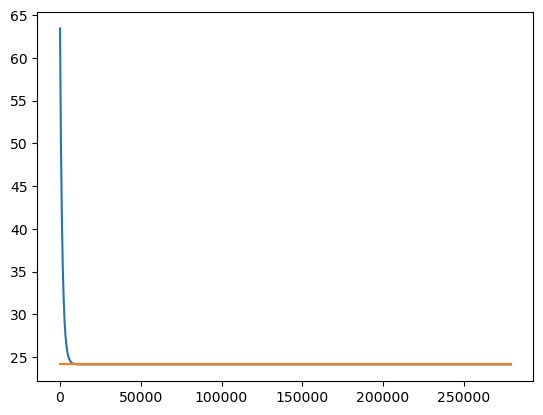

In [290]:
print(cylinder_mass * cp * (forced_high_data[:, 1].max() - forced_high_data[:, 1].min() ))
print(cylinder_mass * cp * (forced_low_data[:, 1].max() - forced_low_data[:, 1].min() ))
print(cylinder_mass * cp * (natural_data[:, 1].max() - natural_data[:, 1].min() ))

time = np.linspace(0, 279_217, 1000)

T = analyticalT(time, tau_natural, Ti_natural, Tinf_natural)
def T_solve(time, a, b, c):
    return analyticalT(time, a, b, c) - 0.1 + Tinf_natural
plt.plot(time, T)
plt.plot(time, time * 0 + 0.1 + Tinf_natural)

print(opt.fsolve(T_solve,x0=7000, args=(tau_natural, Ti_natural, Tinf_natural)))

print(T[-1])
print(0.1 + Tinf_natural)
